#### 1.設置環境

驗證環境是否正確

In [ ]:
import sys, pkgutil
print("Python:", sys.executable)
print("ipykernel ok:", pkgutil.find_loader("ipykernel") is not None)

# 如需 GPU，附加測試（沒有 GPU 可忽略）
try:
    import torch
    print("Torch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print(torch.cuda.get_device_name(0))
except Exception as e:
    print("Torch import error:", e)


Python: c:\Users\Lab902\anaconda3\python.exe
ipykernel ok: True
Torch import error: No module named 'torch'


C:\Users\Lab902\AppData\Local\Temp\ipykernel_22872\308511877.py:3: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  print("ipykernel ok:", pkgutil.find_loader("ipykernel") is not None)


確保不會出現編碼錯誤

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

下載YOLOv12套件

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

^C


ModuleNotFoundError: No module named 'ultralytics'

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.2 MB 342.7 kB/s eta 0:00:17
   --- ------------------------------------ 0.5/6.2 MB 342.7 kB/s eta 0:00:17
   --- ------------------------------------ 0.5/6.2 MB 342.7 kB/s eta 0:00:17
   --- ------------------------------------ 0.5/6.2 MB 342.7 kB/s eta 0:00:17
   --- ------------------------------------ 0.5/6.2 MB 342.7 kB

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxslim 0.1.65 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Lab902\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


#### 2. 上傳資料集和 .yaml 檔

.yaml 檔內容

.yaml 範例:https://drive.google.com/file/d/13hSr3sa2wOZqlvY1RAwr2msCfTdkfjMe/view?usp=sharing

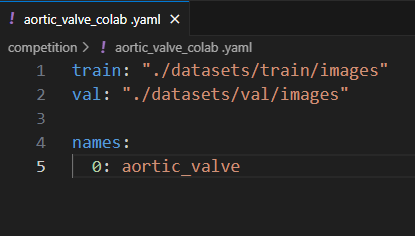



移動檔案(透過下方程式，執行時間<1分鐘)


此範例將前30筆資料用於訓練，後20筆資料用於驗證，參賽者可在程式中53行及56行更改比例

因為Colab運算資源有限此處只採用有標註檔的圖片，其餘圖片也可以自行修改程式利用

將前30筆資料的圖片全部移動至./datasets/train/images，


 前30筆資料的標註全部移動至./datasets/train/labels，


 後20筆資料的圖片全部移動至./datasets/val/images，


 後20筆資料的標註全部移動至./datasets/val/labels。


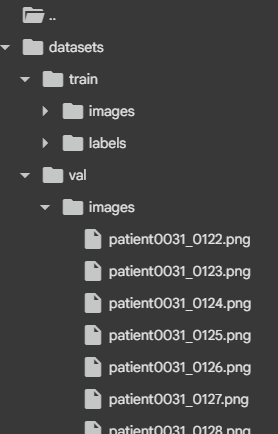

In [ ]:
import os, zipfile, shutil

def unzip_if_needed(zip_path, dest_dir):
    if os.path.isdir(dest_dir):
        return
    if os.path.exists(zip_path):
        os.makedirs(dest_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(dest_dir)

def find_patient_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root

# 解壓縮（不使用外部 unzip 指令）
unzip_if_needed("training_image.zip", "./training_image")
unzip_if_needed("training_label.zip", "./training_label")

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

# 建立輸出資料夾
for p in ["./datasets/train/images","./datasets/train/labels",
          "./datasets/val/images","./datasets/val/labels"]:
    os.makedirs(p, exist_ok=True)

def move_patients(start, end, split):
    moved = 0
    for i in range(start, end + 1):
        patient = f"patient{i:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)
        if not (os.path.isdir(img_dir) and os.path.isdir(lbl_dir)):
            continue
        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue
            base = os.path.splitext(fname)[0]
            img_path = os.path.join(img_dir, base + ".png")
            lbl_path = os.path.join(lbl_dir, base + ".txt")
            if not os.path.exists(img_path):
                continue
            dst_img = f"./datasets/{split}/images/{base}.png"
            dst_lbl = f"./datasets/{split}/labels/{base}.txt"
            if os.path.exists(dst_img): os.remove(dst_img)
            if os.path.exists(dst_lbl): os.remove(dst_lbl)
            shutil.move(img_path, dst_img)
            shutil.move(lbl_path, dst_lbl)
            moved += 1
    return moved

n_train = move_patients(1, 30, "train")
n_val   = move_patients(31, 50, "val")

print(f"完成移動：train {n_train} 筆，val {n_val} 筆")


確認檔案是否成功移動


如果資料數量符合下圖數量代表移動成功

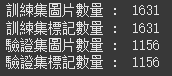

In [ ]:
print('訓練集圖片數量 : ',len(os.listdir("./datasets/train/images")))
print('訓練集標記數量 : ',len(os.listdir("./datasets/train/labels")))
print('驗證集圖片數量 : ',len(os.listdir("./datasets/val/images")))
print('驗證集標記數量 : ',len(os.listdir("./datasets/val/labels")))

#### 3. 訓練模型

執行後依序有Epoch在跑代表成功

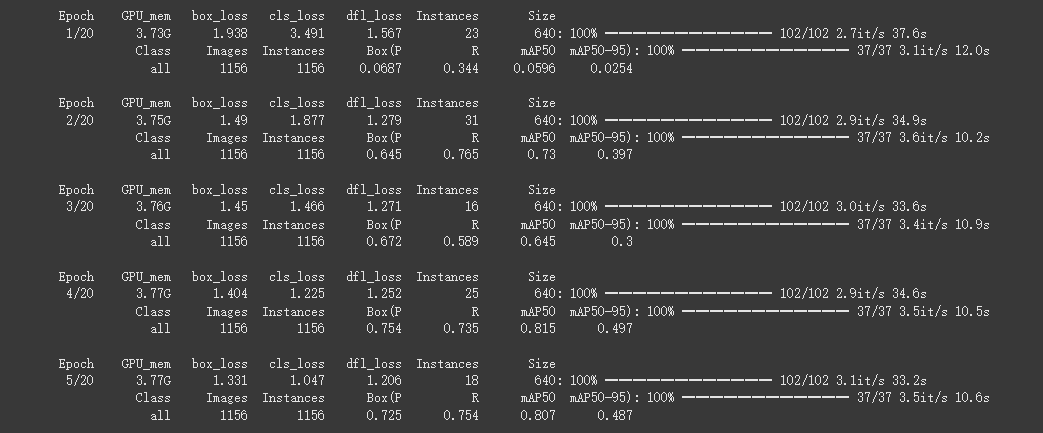

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo12n.pt') #初次訓練使用YOLO官方的預訓練模型，如要使用自己的模型訓練可以將'yolo12n.pt'替換掉
results = model.train(data="./aortic_valve_colab.yaml",
            epochs=10, #跑幾個epoch
            batch=16, #batch_size
            imgsz=640, #圖片大小640*640
            device=0 #使用GPU進行訓練
            )

訓練完左方檔案會有run資料夾，此份ipynb主要目標是得到best.pt用於進行預測!

(!!如果有重複訓練**請下載最後成功**的train編號資料夾)

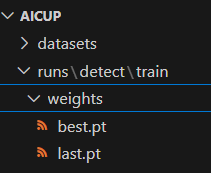

 #### 4. 資料集處理


In [ ]:
import os, zipfile, shutil

def unzip_if_needed(zip_path, dest_dir):
    if os.path.isdir(dest_dir):
        return
    if os.path.exists(zip_path):
        os.makedirs(dest_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(dest_dir)

def find_patient_root(root):
    for dirpath, dirnames, _ in os.walk(root):
        if any(d.lower().startswith("patient") for d in dirnames):
            return dirpath
    return root

# 解壓縮（不使用外部 unzip 指令）
unzip_if_needed("testing_image.zip", "./testing_image")

TEST_ROOT = find_patient_root("./testing_image")

# 建立輸出資料夾
DST_TEST = "./datasets/test/images"
os.makedirs(DST_TEST, exist_ok=True)

# 收集所有圖片路徑（只看直屬的 patient 資料夾）
all_files = []
for patient_folder in os.listdir(TEST_ROOT):
    patient_path = os.path.join(TEST_ROOT, patient_folder)
    if os.path.isdir(patient_path) and patient_folder.lower().startswith("patient"):
        for fname in os.listdir(patient_path):
            if fname.lower().endswith(".png"):
                all_files.append(os.path.join(patient_path, fname))

# 按名稱排序並複製
all_files.sort()
copied = 0
for f in all_files:
    dst = os.path.join(DST_TEST, os.path.basename(f))
    if os.path.exists(dst): os.remove(dst)  # 不想覆蓋就刪掉這行
    shutil.copy2(f, dst)
    copied += 1

print(f"來源根目錄：{TEST_ROOT}")
print(f"完成複製！總共 {copied} 張，全部到 {DST_TEST}")


In [ ]:
print('測試集圖片數量 : ',len(os.listdir("./datasets/test/images")))

#### 5. 預測

使用訓練過模型進行預測圖片

In [ ]:
from ultralytics import YOLO

model = YOLO(r'.\runs\detect\train\weights\best.pt') #請自行更改最新的best.pt檔路徑
results = model.predict(source="./datasets/test/images/",
              save=True,
              imgsz=640,
              device=0
              )

predict資料夾內**有圖片代表預測完成**


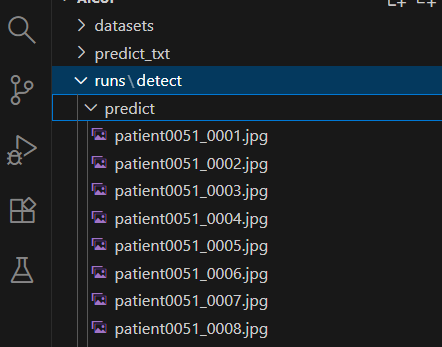

其中一張預測結果

In [ ]:
from IPython.display import Image

Image(filename='./runs/detect/predict/patient0051_0260.jpg', height=600)

預測數量

In [ ]:
print(len(results))

取得預測結果的資訊

想取得更多資訊可參考官方說明
https://docs.ultralytics.com/zh/modes/predict/#boxes

In [ ]:
print('預測類別 : ',results[260].boxes.cls[0].item())
print('預測信心分數 : ',results[260].boxes.conf[0].item())
print('預測框座標 : ',results[260].boxes.xyxy[0].tolist())

將偵測框數值寫進.txt檔

In [ ]:

os.makedirs('./predict_txt', exist_ok=True)


output_file = open('./predict_txt/images.txt', 'w', encoding='utf-8')

for i in range(len(results)):
    filename = str(results[i].path).replace('\\', '/').split('/')[-1].split('.png')[0]
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())
    if box_num > 0:
        for j in range(box_num):
            label = int(boxes.cls[j].item())
            conf = boxes.conf[j].item()
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)
output_file.close()


釋放記憶體


In [ ]:
import torch ,gc

# 刪除大型變數
del boxes,all_files,results
gc.collect()
torch.cuda.empty_cache()